# Imports and configuration

In [22]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import random
from dataclasses import dataclass, field
from torch.utils.data import DataLoader, TensorDataset

# Tokenizer

In [3]:
# Tokenizer, we want BOS, EOS tokens
vocab = ['<PAD>', ' 1', ' 2', ' 3', ' 4', ' 5', ' 6', ' 7', ' 8', ' 9', '\n', 'Ball', 'There are', ' is in', 'Switch', ' switches', ' of', ' and', ' cup', ' cups']

setattr(MASTER_CONFIG, "vocab", vocab)
setattr(MASTER_CONFIG, "vocab_size", len(vocab))

idx_to_s = {i:ch for i, ch in enumerate(vocab)}
s_to_idx = {ch:i for i, ch in enumerate(vocab)}


def encode_tokens(s: str) -> list[int]:
    ids = []
    i = 0
    while i < len(s):
        max_len = -1
        max_token = None
        for token in s_to_idx.keys():
            token_len = len(token)
            if s[i:i+token_len] == token:
                if token_len > max_len:
                    max_len = token_len
                    max_token = token
        if max_token:
            ids.append(s_to_idx[max_token])
            i += max_len
        else:
            print(f"Unrecognized sequence at index {i}, {s[i:i+1]}")
            
            break

    return ids

def decode_tokens(ids: list[int]) -> str:
    return "".join([idx_to_s[i] for i in ids])

# Ball Shuffler

In [27]:
import random

def initial_ball_position(n=3):
    return random.randint(1, n)

def generate_shuffle_moves(n=3, num_moves=3):
    moves = []
    
    for _ in range(num_moves):
        # Randomly pick two different cups
        cup1, cup2 = random.sample(range(1, n + 1), 2)
        moves.append((cup1, cup2))
    
    return moves

def final_ball_position(initial_position, shuffle_moves):
    position = initial_position
    for move in shuffle_moves:
        # If the ball's current position matches one of the cups in the move, swap it.
        if position == move[0]:
            position = move[1]
        elif position == move[1]:
            position = move[0]
    
    return position
    
# Generate batches of data
def generate_batch_cup_data(n_cups = 3, num_examples=1000, num_moves=3, verbose=False):
    inputs_idx = []
    targets_idx = []
    pad_token = encode_tokens('<PAD>')
    pad_token_tensor = torch.tensor(pad_token[0])
    
    for _ in range(num_examples):
        n_moves = random.choice(range(1,num_moves))

        input, target = generate_masked_cup_shuffling_scenario(n_cups=n_cups, n_moves=n_moves)
        inputs_idx.append(encode_tokens(input))

        # Finds the last cup number in the string
        targets_idx.append(encode_tokens(target))
    
    max_inputs_len = max(len(input) for input in inputs_idx)
    
    padded_input_ids = [input + pad_token * (max_inputs_len - len(input)) for input in inputs_idx]
    target_ids = [targets for targets in targets_idx]
        
    input_tensor = torch.tensor(padded_input_ids, dtype=torch.long)
    target_tensor = torch.tensor(target_ids, dtype=torch.long)

    masked_tensor = (input_tensor == pad_token_tensor).long().argmax(dim=1) 
    
    return input_tensor, target_tensor, masked_tensor
    
def dim(a):
    if not type(a) == list:
        return []
    return [len(a)] + dim(a[0])

def dims(a):
    for i in range(len(a)):
        print(f"Len of dimension {i}: {len(a[i])}")

def generate_cup_shuffling_scenario(n=3, num_moves=3):
    # Generate initial ball position and shuffle movesx
    initial_position = initial_ball_position(n)
    shuffle_moves = generate_shuffle_moves(n, num_moves)
    
    # Calculate the final ball position
    final_position = final_ball_position(initial_position, shuffle_moves)
    
    # Construct the input and output strings
    string = f"There are {n} cups and {num_moves} switches of cups\n"
    string += f"Ball is in cup {initial_position}\n"
    string += "\n".join([f"Switch cup {move[0]} and cup {move[1]}" for move in shuffle_moves])
    string += f"\nBall is in cup {final_position}"
    
    return string

def generate_masked_cup_shuffling_scenario(n_cups=3, n_moves=3):
    # Generate initial ball position and shuffle moves
    initial_position = initial_ball_position(n_cups)
    shuffle_moves = generate_shuffle_moves(n_cups, n_moves)
    
    # Calculate the final ball position for tokenizing
    final_position = " " + str(final_ball_position(initial_position, shuffle_moves))
    
    # Construct the input and output strings
    input = f"There are {n_cups} cups and {n_moves} switches of cups\n"
    input += f"Ball is in cup {initial_position}\n"
    input += "\n".join([f"Switch cup {move[0]} and cup {move[1]}" for move in shuffle_moves])
    input += f"\nBall is in cup<PAD>"
    
    return input, final_position

class CupDataset(Dataset):
    def __init__(self, data, split='train', config=None):
        self.inputs, self.targets, self.masked_positions = self._prepare_data(data, split, config)

    def _prepare_data(self, data, split, config):
        # Assuming generate_batch_cup_data is your data generation function
        if split not in ["train", "val"]:
            raise ValueError("split must be either 'train' or 'val'")

        # Generate data
        generated_data = generate_batch_cup_data(n_cups=config.n_cups, 
                                                 num_moves=config.n_moves, 
                                                 num_examples=config.n_samples)
       

        # Split the data
        split_index = int(config.training_split * len(generated_data[0]))
        if split == 'train':
            split_data = [d[:split_index] for d in generated_data]
            print(f"Splitting data into {len(split_data[0])} training examples")
            return split_data
        else:  # split == 'val'
            split_data = [d[split_index:] for d in generated_data]
            print(f"Splitting data into {len(split_data[0])} validation examples")
            return split_data
        
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            "inputs": self.inputs[idx],
            "targets": self.targets[idx],
            "masked_positions": self.masked_positions[idx]
        }


In [5]:
generate_batch_cup_data(num_examples=3, verbose=True)

(tensor([[12,  3, 19, 17,  1, 15, 16, 19, 10, 11, 13, 18,  2, 10, 14, 18,  1, 17,
          18,  3, 10, 11, 13, 18,  0,  0,  0,  0,  0,  0,  0,  0],
         [12,  3, 19, 17,  2, 15, 16, 19, 10, 11, 13, 18,  3, 10, 14, 18,  3, 17,
          18,  1, 10, 14, 18,  3, 17, 18,  1, 10, 11, 13, 18,  0],
         [12,  3, 19, 17,  2, 15, 16, 19, 10, 11, 13, 18,  2, 10, 14, 18,  1, 17,
          18,  3, 10, 14, 18,  3, 17, 18,  2, 10, 11, 13, 18,  0]]),
 tensor([[2],
         [3],
         [3]]),
 tensor([24, 31, 31]))

In [6]:

s = generate_cup_shuffling_scenario(4, 5)
print(s)

print(f"The string is {len(encode_tokens(s))} tokens long:\n\n{s}\n\nAnd has the following tokenization:\n{encode_tokens(s)}")


There are 4 cups and 5 switches of cups
Ball is in cup 4
Switch cup 2 and cup 4
Switch cup 4 and cup 1
Switch cup 3 and cup 2
Switch cup 3 and cup 2
Switch cup 3 and cup 1
Ball is in cup 2
The string is 53 tokens long:

There are 4 cups and 5 switches of cups
Ball is in cup 4
Switch cup 2 and cup 4
Switch cup 4 and cup 1
Switch cup 3 and cup 2
Switch cup 3 and cup 2
Switch cup 3 and cup 1
Ball is in cup 2

And has the following tokenization:
[12, 4, 19, 17, 5, 15, 16, 19, 10, 11, 13, 18, 4, 10, 14, 18, 2, 17, 18, 4, 10, 14, 18, 4, 17, 18, 1, 10, 14, 18, 3, 17, 18, 2, 10, 14, 18, 3, 17, 18, 2, 10, 14, 18, 3, 17, 18, 1, 10, 11, 13, 18, 2]


In [7]:
initial_position = initial_ball_position()
print(initial_position)

shuffle_moves = generate_shuffle_moves()
print(shuffle_moves)

final_position = final_ball_position(initial_position, shuffle_moves)
print(final_position)

scenario = generate_masked_cup_shuffling_scenario()
print(scenario)


#print(generate_cup_data(n_cups=3, num_moves=range(1,5), num_examples=1))

2
[(2, 1), (2, 1), (1, 2)]
1
('There are 3 cups and 3 switches of cups\nBall is in cup 1\nSwitch cup 1 and cup 2\nSwitch cup 2 and cup 3\nSwitch cup 1 and cup 2\nBall is in cup<PAD>', ' 3')


In [8]:
print(generate_batch_cup_data(4, 2, 5))

(tensor([[12,  4, 19, 17,  3, 15, 16, 19, 10, 11, 13, 18,  4, 10, 14, 18,  4, 17,
         18,  3, 10, 14, 18,  3, 17, 18,  2, 10, 14, 18,  2, 17, 18,  1, 10, 11,
         13, 18,  0],
        [12,  4, 19, 17,  3, 15, 16, 19, 10, 11, 13, 18,  2, 10, 14, 18,  2, 17,
         18,  1, 10, 14, 18,  4, 17, 18,  3, 10, 14, 18,  3, 17, 18,  2, 10, 11,
         13, 18,  0]]), tensor([[1],
        [1]]), tensor([38, 38]))


# Models, functions and layers

In [9]:
class DummyModel(nn.Module):
    """
    Dummy model for testing purposes. It takes a sequence of tokens and returns a probability distribution over the vocabulary.
    
    Input: x a sequence of tokens of shape (B, T)
    Output: a probability distribution over the vocabulary of shape (B, T, vocab_size)
    Parameters: 
    """
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config
        
        vocab_size = config.vocab_size
        d_model = config.d_model
        
        # Embedding layer from the vocabulary to the d_model dimension, parameter matrix W_e in R^{vocab_size x d_model}
        self.embedding = nn.Embedding(vocab_size, d_model)
        # Linear layer from d_model to vocab_size dimension. Parameter matrices W_l1, W_l2 in R^{d_model x d_model}, R^{d_model x vocab_size}
        self.linear = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, vocab_size)
        )
        
        # Returns the number of parameters in the model
        self.num_parameters = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
    def forward(self, x, targets=None):
        # x is of shape (B, T), each element is an integer in the range [0, vocab_size) representing a token. By seeing each token as a one-hot vector, x can be seen as a tensor of shape (B, T, vocab_size)
        B, T = x.shape
        
        # Embedd x into the d_model dimension which makes x of shape (B, T, d_model)
        x = self.embedding(x)
        
        # MLP layer into an unembedding layer, which makes x of shape (B, T, vocab_size)
        x = self.linear(x)
        
        # Softmax over the vocabulary dimension which is the last dimension, returns a probability distribution over the vocabulary, it is of shape (B, T, vocab_size)
        logits = F.softmax(x, dim=-1)
        
        if targets is not None:
            # Calculate the loss
            
            # Flatten the logits and targets to be of shape (B*T, vocab_size) and (B*T) respectively
            x = x.view(B*T, self.vocab_size)
            targets = targets.view(B*T)
            
            loss = F.cross_entropy(logits, targets)
            return loss, logits
        
        return logits

In [10]:
class positional_encoding(nn.Module):
    """ 
    Positional encoding according to [VSP17] paper "Attention is all you need" based on sine and cosine functions.
    
    B = batch size
    T = sequence length
    d_model = embedding dimension
    
    Input: x a sequence of tokens of shape (B, T, d_model)
    Output: p, where p is the positional encoding, of shape (B, T, d_model)
    """
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        d_model = config.d_model
        l_max = config.l_max
        dtype = config.dtype
        
        self.p = torch.zeros((1, l_max, d_model)) #TODO: Is this really necessary? Should this be l_max, d_model instead?
        num = torch.arange(l_max, dtype=dtype).reshape(-1, 1) # Creates X = [[0], [1], ..., [l_max - 1]]
        denum = torch.pow(10000, torch.arange(0, d_model, 2, dtype=dtype) / d_model) # Creates Y = [10000^0/d_model, 10000^2/d_model, ..., 10000^(d_model - 1)/d_model]
        self.p[:, :, 0::2] = torch.sin(num / denum)
        self.p[:, :, 1::2] = torch.cos(num / denum)
        
    def forward(self, x):
        return self.p[:, :x.shape[1], :].to(x.device)

class AttentionHead(nn.Module):
    def __init__(self, d_q, d_v, d_attn, d_out, bias=False, config=MASTER_CONFIG, mask=None):
        super().__init__()

        # Linear layers for Q, K, V of dimensions dq, dv, dv respectively
        # TODO: More efficient to do the linear transformation together and then split the result?
        # TODO: Allow a toggle for whether to use bias or not
        self.linear_q = nn.Linear(d_attn, d_q, bias=bias)
        self.linear_k = nn.Linear(d_attn, d_v, bias=bias)
        self.linear_v = nn.Linear(d_out, d_v, bias=bias)
        
    def forward(self, x, mask=None):
        _, _, D = x.shape # x is of shape (B, T, d_model) TODO: Maybe should make this dynamic through reshaping -1?
        
        q = self.linear_q(x) # (B, T, d_model)
        k = self.linear_k(x) # (B, T, d_model)
        v = self.linear_v(x) # (B, T, d_model)
        
        S = torch.bmm(q, k.transpose(1, 2)) / np.sqrt(D) # Calculate the attention weights (B, T, d_model) * (B, d_model, T) = (B, T, T)
        
        if mask == None:
            weights = S
        else:
            weights = S.masked_fill(mask == 0, -1e9)
            
        weights = F.softmax(weights, dim=-1) # Apply the softmax on the last dimension, meaning the last dimension sums to 1
        v_bar = torch.bmm(weights, v) # Apply the attention weights to the values (B, T, T) * (B, T, d_model) = (B, T, d_model)
        # Y_t = att(X_t W_h^Q, X_t W_h^K, X_t W_h^V) = softmax((X_t W_h^Q)(X_t W_h^K)^t / sqrt(d_model)) (X_t W_h^V)

        return v_bar
        

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, mask=None):
        super().__init__()
        self.n_heads = n_heads
        
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        head_size = d_model // n_heads
        
        self.heads = nn.ModuleList(
            [AttentionHead(d_attn = head_size, d_out = head_size, d_q=d_model, d_v=d_model, mask=mask) for _ in range(n_heads)]
        )
        
        self.linear_o = nn.Linear(d_model * n_heads, d_model)
        
    def forward(self, x):
        H = self.n_heads

        B, T, _ = x.shape # x is of shape (B, T, d_model)
        
        x = x.view(B, T, H, -1) # Reshape x to (B, T, n_heads, d_model/n_heads)
        x = x.transpose(1, 2) # Transpose to get shape (B, n_heads, T, d_model/n_heads)
        
        v = [head(x[:, i, :, :]) for i, head in enumerate(self.heads)] # Apply attention heads to shape (B, 1, T, d_model/n_heads)

        v = torch.stack(v, dim=1) # Stack heads to get shape (B, n_heads, T, d_model/n_heads)
        v = v.transpose(1, 2).contiguous().view(B, T, -1) # Reshape to (B, T, d_model)
        #TODO: Understand what this transformation does
        
        v_bar = self.linear_o(v) # Apply the linear layer (B, T, d_model) -> (B, T, d_model)
        
        return v_bar
    
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, n_heads, mask=None):
        super().__init__()

        self.ln_mha = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model=d_model, n_heads=n_heads, mask=mask)
        
        self.fcn = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )
        
    def forward(self, x):
        # x is of shape (B, T, d_model)
        
        x = self.ln_mha(x) # (B, T, d_model) -> (B, T, d_model)
        x = self.mha(x) + x # (B, T, d_model) -> (B, T, d_model)
        x = self.fcn(x) + x # (B, T, d_model) -> (B, T, d_model)
        
        return x

class cup_GPT(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config
        
        self.d_model = config.d_model
        self.n_heads = config.n_heads
        self.d_model = config.d_model
        self.vocab_size = config.vocab_size  # Define vocab_size here
        self.n_layers = config.n_layers
        self.l_max = config.l_max
        self.causal = config.causal
        
        d_model = config.d_model
        n_heads = config.n_heads
        d_model = config.d_model
        vocab_size = config.vocab_size
        n_layers = config.n_layers
        l_max = config.l_max
        causal = config.causal
        
        if causal: #Causal mask
            mask = torch.triu(torch.ones((l_max, l_max)), diagonal=1)
        else:
            mask = None

        
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = positional_encoding(config)
        
        self.mha_layers = nn.ModuleList(
            [MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads, mask=mask) for _ in range(n_layers)]
        )
        
        self.ln = nn.LayerNorm(d_model)
        self.unembed = nn.Linear(d_model, vocab_size)
        
    def forward(self, x, targets=None):
        B, T = x.shape # x is of shape (B, T)

        x = self.embed(x) # Embed the tokens (B, T) -> (B, T, d_model)

        x = x + self.pos_enc(x) # Add the positional encoding (B, T, d_model) -> (B, T, d_model)

        for mha_layer in self.mha_layers: 
            x = mha_layer(x) # Apply the MHA layers (B, T, d_model) -> (B, T, d_model)
        
        x = self.ln(x) # Apply the layer norm (B, T, d_model) -> (B, T, d_model)
        unnorm_logits = self.unembed(x) # Apply the unembedding layer (B, T, d_model) -> (B, T, vocab_size), unnormalized logits
        
        if targets is not None:            
            # Flatten the logits and targets to make the calculation more efficient and return a single value

            #unnorm_logits = unnorm_logits.view(B*T, self.vocab_size) # (B, T, vocab_size) -> (B*T, vocab_size)
  
            #targets = targets.view(B) # (B, T) -> (B*T)
            targets = targets.view(B)
            # Cross entropy loss in PyTorch takes the unnormalized logits and the targets, so we don't need to softmax the logits.
            loss = F.cross_entropy(unnorm_logits, targets, ignore_index = encode_tokens('<PAD>')[0])
            
        else:
            loss = None
            
        return unnorm_logits, loss
    
# TODO: Next steps are to implement the decoder part of the transformer.
# TODO: Understand how cross entropy loss works in PyTorch

# Testing batch generator

# Initializing dummy model

In [11]:
config = MASTER_CONFIG
data = generate_batch_cup_data(config.n_cups, config.n_moves, config.n_samples)

model = DummyModel(config)
#model.to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

print(MASTER_CONFIG.vocab_size)

# Test model
x = torch.randint(MASTER_CONFIG.vocab_size, (1, 3))
y = model(x)

print(x, y)

Unrecognized sequence at index 22, 9
Unrecognized sequence at index 22, 9
Unrecognized sequence at index 22, 1
Unrecognized sequence at index 22, 7
20
tensor([[ 4, 16, 10]]) tensor([[[0.0446, 0.0682, 0.0492, 0.0515, 0.0320, 0.0436, 0.0386, 0.0636,
          0.0699, 0.0470, 0.0383, 0.0323, 0.0505, 0.0479, 0.0914, 0.0454,
          0.0397, 0.0399, 0.0553, 0.0512],
         [0.0426, 0.0493, 0.0804, 0.0472, 0.0510, 0.0570, 0.0570, 0.0430,
          0.0586, 0.0440, 0.0472, 0.0471, 0.0474, 0.0603, 0.0369, 0.0426,
          0.0528, 0.0460, 0.0490, 0.0406],
         [0.0312, 0.0501, 0.0685, 0.0374, 0.0394, 0.0586, 0.0537, 0.0644,
          0.0623, 0.0564, 0.0554, 0.0329, 0.0394, 0.0562, 0.0543, 0.0652,
          0.0418, 0.0315, 0.0576, 0.0437]]], grad_fn=<SoftmaxBackward0>)


In [30]:
# Create a config file for the cup shuffling task
@dataclass
class MASTER_CONFIG:
    # Training
    seed: int = 1337
    batch_size: int = 32
    training_split: float = 0.8
    
    epochs = 1
    batch_eval_internal = 10
    learning_rate = 2e-5
    eval_iters = 50
    
    # Model parameters
    dtype: torch.dtype = torch.float32
    d_model: int = 128 # This is the size of the embedding
    l_max: int = 128 # Max sequence length
    n_heads: int = 8 # Number of heads in the multi-head attention
    n_layers: int = 8 # Number of layers in the transformer of MHA blocks
    dropout: float = 0.1 # Dropout rate
    causal: bool = True # Whether to use a causal mask in the attention layer
    
    # Data parameters
    n_cups: int = 3
    n_moves: int = 4
    n_samples: int = 10000

    # Tokenizer
    vocab: list[str] = field(default_factory = lambda: [])
    vocab_size: int = 0
    
    # Use CUDA or MPS if available else CPU
    if (torch.cuda.is_available()):
        device = torch.device("cuda")
        print("Using CUDA")
    elif (torch.backends.mps.is_available()):
        device = torch.device("mps")
        print("Using Apple Silicon MPS")
    else:
        device = torch.device("cpu")
        print("Using CPU")
        
setattr(MASTER_CONFIG, "vocab", vocab)
setattr(MASTER_CONFIG, "vocab_size", len(vocab))

train_dataset = CupDataset(data, split='train', config=MASTER_CONFIG)
val_dataset = CupDataset(data, split='val', config=MASTER_CONFIG)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=MASTER_CONFIG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=MASTER_CONFIG.batch_size, shuffle=False)


Using Apple Silicon MPS
Splitting data into 8000 training examples
Splitting data into 2000 validation examples


In [31]:

# Method for evaluating the loss of the PyTorch model on the validation set without defining the model.
@torch.no_grad()
def evaluate_model(model):
    out = {}
    model.eval()

    for split, loader in [("train", train_loader), ("val", val_loader)]:
        total_loss = 0.0
        total_tokens = 0

        for batch in loader:
            # Get the inputs and targets
            inputs = batch["inputs"]
            targets = batch["targets"]
            mask_tensor = batch["masked_positions"]

            # Get the model outputs
            logits, _ = model(inputs)

            target_logits = logits[torch.arange(logits.size(0)), mask_tensor]

            loss = F.cross_entropy(target_logits, targets.squeeze(1))

            # Update the total loss and tokens
            total_loss += loss.item() * targets.numel()
            total_tokens += targets.numel()

        # Calculate the average loss
        avg_loss = total_loss / total_tokens if total_tokens > 0 else 0

        # Store the average loss
        out[split] = avg_loss

    model.train()
    return out

# Train the model with evaluate_model
def train_model(model, optimizer, config=MASTER_CONFIG):
    # Set the model to train mode
    model.train()
    
    # Initialize the losses
    losses = []
    
    # Initialize the timer
    start = time.time()
    
    # Loop over the training data
    for i, batch in enumerate(train_loader):
        # Get the inputs and targets
        inputs = batch["inputs"]
        targets = batch["targets"]
        mask_tensor = batch["masked_positions"]
          
        #Inputs should be the tokens before the masked token, target is in targets
        
        #Find position of masked token

        # Get the model outputs
        logits, _ = model(inputs)

        target_logits = logits[torch.arange(logits.size(0)), mask_tensor]

        loss = F.cross_entropy(target_logits,targets.squeeze(1))
        # Backpropagate the loss
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Append the loss
        losses.append(loss.item())
        
        # Print the loss every 100 iterations
        if i % config.batch_size * 10 == 0:
            print(f"Training batch {i}, loss = {loss.item()}")
            
        # Evaluate the model every 1000 iterations
        if i % config.batch_size * 100 == 0:
            print(f"Evaluating model at batch {i}")
            eval_out = evaluate_model(model)
            print(f"Train loss = {eval_out['train']}, val loss = {eval_out['val']}")
            
    # Evaluate the model at the end of training
    print("Evaluating model...")
    eval_out = evaluate_model(model)
    print(f"Train loss = {eval_out['train']}, val loss = {eval_out['val']}")
    
    # Print the total time
    print(f"Total time: {time.time() - start} seconds")
    
    # Plot the losses
    plt.plot(losses)
    plt.show()
    
    return model

In [18]:
config = MASTER_CONFIG
print(f'Generating data with n_cups={config.n_cups}, n_moves={config.n_moves}, n_samples={config.n_samples}, batch_size={config.batch_size}, vocab_size={config.vocab_size}')
data = generate_batch_cup_data(n_cups=config.n_cups, num_moves=config.n_moves, num_examples=config.n_samples)

model = cup_GPT(config)
#model.to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
pad_token = encode_tokens('<PAD>')[0]

print(MASTER_CONFIG.vocab_size)

# Test model
x = torch.randint(MASTER_CONFIG.vocab_size, (1, 3))
y = model(x)

print(x, y)


Generating data with n_cups=3, n_moves=4, n_samples=10000, batch_size=32, vocab_size=20
20
tensor([[ 9, 14,  9]]) (tensor([[[ 2.3203e-01, -2.9523e-01,  1.2519e+00, -1.3443e-01, -1.3294e+00,
           3.3945e-01,  1.4770e-02, -4.6676e-01,  4.9124e-02, -2.6949e-01,
          -5.5600e-01, -5.0882e-01,  2.9033e-01,  1.2832e-01, -6.4934e-01,
          -3.0696e-01, -8.5421e-01,  2.9223e-01, -1.2287e-01, -1.4117e-01],
         [ 3.4416e-01, -1.1964e-01,  7.7959e-01, -2.1890e-01,  7.0181e-02,
          -6.5842e-01, -6.8734e-01, -1.0740e+00,  6.4855e-01,  7.7778e-01,
          -6.9414e-01,  5.8650e-01,  6.3919e-01, -2.7299e-01,  1.4213e-01,
           4.9779e-01, -1.6237e-01,  5.7770e-01,  7.5170e-04,  1.1264e+00],
         [ 8.8718e-02, -2.2076e-01,  1.1535e+00, -1.4537e-01, -1.1936e+00,
           3.7512e-01, -1.2351e-01, -3.2630e-01,  2.2841e-01, -3.5481e-01,
          -2.8327e-01, -5.4179e-01,  5.2615e-01, -3.9111e-02, -8.0689e-01,
          -3.5577e-01, -7.5612e-01,  3.8035e-01, -1.2212e-

Training batch 0, loss = 2.8932416439056396
Evaluating model at batch 0
Train loss = 2.6932676572799683, val loss = 2.688978326797485
Training batch 32, loss = 1.318631887435913
Evaluating model at batch 32
Train loss = 1.2874597601890565, val loss = 1.2822902240753173
Training batch 64, loss = 1.209417462348938
Evaluating model at batch 64
Train loss = 1.2151226558685302, val loss = 1.2123510532379151
Training batch 96, loss = 1.1852139234542847
Evaluating model at batch 96
Train loss = 1.1941762943267822, val loss = 1.1916492013931275
Training batch 128, loss = 1.1818726062774658
Evaluating model at batch 128
Train loss = 1.1825769424438477, val loss = 1.1834708709716797
Training batch 160, loss = 1.1660935878753662
Evaluating model at batch 160
Train loss = 1.1750778794288634, val loss = 1.1739778289794922
Training batch 192, loss = 1.1539227962493896
Evaluating model at batch 192
Train loss = 1.1676292819976806, val loss = 1.1683944873809815
Training batch 224, loss = 1.15366649627

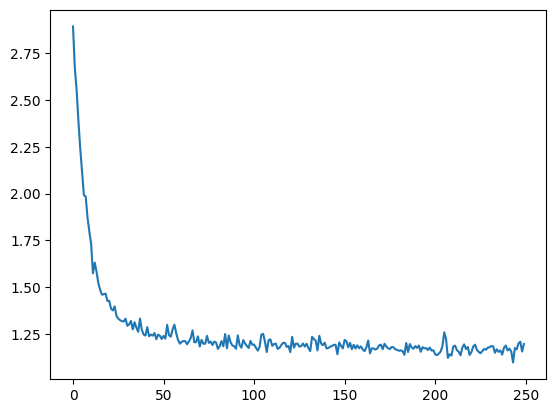

cup_GPT(
  (embed): Embedding(20, 128)
  (pos_enc): positional_encoding()
  (mha_layers): ModuleList(
    (0-7): 8 x MultiHeadAttentionLayer(
      (ln_mha): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x AttentionHead(
            (linear_q): Linear(in_features=16, out_features=128, bias=False)
            (linear_k): Linear(in_features=16, out_features=128, bias=False)
            (linear_v): Linear(in_features=16, out_features=128, bias=False)
          )
        )
        (linear_o): Linear(in_features=1024, out_features=128, bias=True)
      )
      (fcn): Sequential(
        (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=128, out_features=128, bias=True)
      )
    )
  )
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (unembed): 

In [32]:
train_model(model, optimizer, config=MASTER_CONFIG)

In [107]:
# make a function out of this and calculate it several times to get the average error


model.eval()
# Generate a single example
input, final_position = generate_masked_cup_shuffling_scenario(n_cups=MASTER_CONFIG.n_cups, n_moves=MASTER_CONFIG.n_moves)
print(input, final_position)

# Tokenize the input
input_tokens = encode_tokens(input)
# Remove the last token
input_tokens = input_tokens[:-1]
# Convert to a tensor
input_tensor = torch.tensor(input_tokens, dtype=torch.long)
# Add a batch dimension
input_tensor = input_tensor.unsqueeze(0)
# Feed the input to the model
logits, _ = model(input_tensor)
print(logits.shape)
# Get the last logits
last_logits = logits[0, -1, :]
print(logits[0, -5, :])
print(last_logits)
# Get the predicted token
predicted_token = torch.argmax(last_logits).item()
# Get the actual token
actual_token = encode_tokens(final_position)[0]
# Print the predicted and actual tokens
print(f"Predicted token: {idx_to_s[predicted_token]}, actual token: {idx_to_s[actual_token]}")

There are 3 cups and 4 switches of cups
Ball is in cup 3
Switch cup 1 and cup 3
Switch cup 2 and cup 1
Switch cup 2 and cup 3
Switch cup 2 and cup 3
Ball is in cup<PAD>  2
torch.Size([1, 45, 20])
tensor([-0.7675,  3.0841,  2.9102,  3.1480, -0.2242, -0.3099, -0.9413, -0.3617,
        -1.0694, -0.6935, -0.9988, -0.7369, -0.5777, -1.1164, -0.9598, -0.8815,
        -0.3949, -1.8517, -0.3783, -0.0455], grad_fn=<SliceBackward0>)
tensor([-0.2747,  2.9546,  3.2645,  2.9192, -0.5223, -0.3716, -0.7690, -0.1717,
        -0.9421, -1.1152, -0.7523, -1.1083, -0.7179, -0.7794, -0.8758, -0.3516,
        -0.6097, -1.3583, -0.1339, -0.2904], grad_fn=<SliceBackward0>)
Predicted token:  2, actual token:  2


# Tests

In [ ]:
def test_auto_regressive(model, config=MASTER_CONFIG):
    '''
    Tests if the model is auto-regressive by comparing the output of the model when given the entire input sequence and when given the input sequence one token at a time.
    '''
    # TODO: Not sure this works.
    # shape vocab_size, batch_size, block_size
    x = torch.randint(config.vocab_size, (1, 3))
    y1 = model(x)
    
    y2 = torch.zeros_like(y1)
    for b in range(x.size(1)):
        y_b = model(x[:, :b + 1])
        y2[:, b] = y_b[:, b]
            
    error = ((y1 - y2).norm() / (y1.norm() + y2.norm())).item()
    
    if error < 1e-5:
        print("Auto-regressive test passed")
        print(error)
    else:
        print("Auto-regressive test failed")
        print(error)
        
    # print(f"Error={error}")
    
test_auto_regressive(model)



TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not tuple

# Training model

# Miscelanea

In [ ]:
def positional_embedding_naive(t: int, config=MASTER_CONFIG) -> torch.Tensor:
    """
    Input: t the position of the token in a sequence
    Output: the positional embedding of the position
    Parameters: W_p in R^{d_model x l_max} where l_max is the maximum sequence length or context size
    Return: e_p in R^{d_model}

    Using the sine positional embedding from [VSP17] paper "Attention is all you need".
    """
    d_model = config.d_model
    l_max = config.l_max
    
    # Create the positional embedding matrix
    W_p = torch.zeros((d_model, l_max))
    for t in range(l_max):
        for i in range(d_model):
            if i % 2 == 0:
                W_p[i, t] = np.sin(t / 10000 ** (i / d_model)) # TODO: check if this is correct, or should it be l_max instead of 10000?
            else:
                W_p[i, t] = np.cos(t / 10000 ** ((i - i % 2) / d_model))
    
    # Return the positional embedding vector
    return W_p[:, t]
